In [162]:
from matplotlib import pyplot as plt
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import imutils
from easyocr import easyocr, Reader
import cv2
import requests
import os
import numpy as np
from PIL import ImageFont, ImageDraw, Image

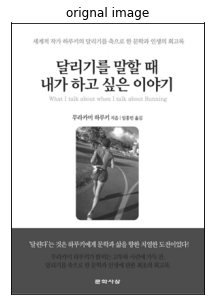

In [163]:
# url = 'http://image.yes24.com/goods/96674785/XL'
# image_nparray =  np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)

url = r'C:\Users\jinhee\project_readvice\readvice_easyOCR\data\images\2.jpg'
image = cv2.imread(url) 
org_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt_imshow("orignal image", org_image)

In [164]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()
 

In [165]:

def make_scan_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
  image_list_title = []
  image_list = []
 
  image = imutils.resize(image, width=width)
  ratio = org_image.shape[1] / float(image.shape[1])
 
  # 이미지를 grayscale로 변환하고 blur를 적용
  # 모서리를 찾기위한 이미지 연산
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, ksize, 0)
  edged = cv2.Canny(blurred, min_threshold, max_threshold)
 
  image_list_title = ['gray', 'blurred', 'edged']
  image_list = [gray, blurred, edged]
 
  # contours를 찾아 크기순으로 정렬
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
 
  findCnt = None
 
  # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
  approx = None
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
    if len(approx) == 4:
      findCnt = approx
      break
 
 
  # 만약 추출한 윤곽이 없을 경우 오류
  if findCnt is None:
    raise Exception(("Could not find outline."))
 
 
  output = image.copy()
  cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)
  
  image_list_title.append("Outline")
  image_list.append(output)
 
  # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
  transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)
 
  plt_imshow(image_list_title, image_list)
  plt_imshow("Transform", transform_image)
 
  return transform_image

In [166]:
def putText(cv_img, text, x, y, color=(0, 0, 0), font_size=22):
  font = ImageFont.truetype('C:/Windows/Fonts/gulim.ttc', font_size)
  img = Image.fromarray(cv_img)
   
  draw = ImageDraw.Draw(img)
  draw.text((x, y), text, font=font, fill=color)
 
  cv_img = np.array(img)
  
  return cv_img

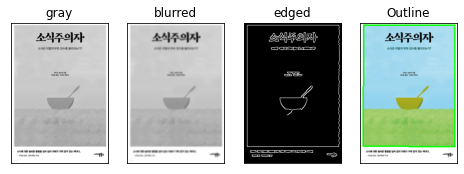

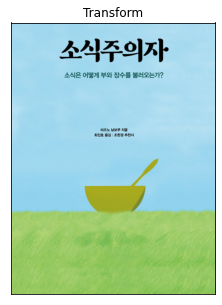

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...


In [171]:
# url = 'http://image.yes24.com/goods/96674785/XL'
# image_nparray =  np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)

url = r'C:\Users\jinhee\project_readvice\readvice_easyOCR\data\images\4.jpg'
org_image = cv2.imread(url, cv2.IMREAD_COLOR) 
# plt_imshow("orignal image", org_image)
book_image = make_scan_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)
langs = ['ko', 'en']
print("[INFO] OCR'ing input image...")
reader = Reader(lang_list=langs, gpu=True)
results = reader.readtext(book_image)
results

In [172]:
simple_results = reader.readtext(book_image, detail = 0)
simple_results

['소식주의자', '소식은 어떻게 부와 장수홀 불러오는가?', '미즈노 남보구 지음', '최진호 유김 | 조한경 추천사']